In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime 
from datetime import timedelta
import os
from constants import *
from trip_file import TripFile
from trip import Trip
from tqdm import tqdm
import seaborn as sns


In [2]:
taarif = pd.read_csv("../files/taarif.csv")
taarif = taarif.drop(0).reset_index().drop(columns=["index"]) # first row is nulls
new_drivers = pd.read_csv("../files/new_drivers.csv", index_col=0)
drivers_with_kviut = pd.read_csv("../files/drivers_with_kviut.csv",index_col=0)

In [3]:
def preprocess_drivers(drivers: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = drivers
    if copy:
        df = drivers.copy()

    gender_mapping = {"F": FEMALE,
                    "M":MALE,
                    "m":MALE,
                    "male":MALE,
                    "boy":MALE,
                    "unknown":UNKOWN,
                    'woman':FEMALE,
                    'girl':FEMALE,
                    'none':UNKOWN,
                    'female':FEMALE,
                    UNKOWN:UNKOWN}

    # Make preprocess
    df.gender = df.gender.fillna(UNKOWN)
    df.gender = df.gender.apply(lambda x: gender_mapping[x])
    df.birthdate = pd.to_datetime(df.birthdate, format="mixed")
    drivers.birthdate = drivers.birthdate.fillna(datetime.datetime.now())

    return df

def preprocess_taarif(taarif_df: pd.DataFrame, copy=False) -> pd.DataFrame:
    df = taarif_df
    if copy:
        df = new_drivers.copy()

    customers_mapping = {
            "dbs" : "yes",
            "mizranei_kfar_saba": "aminach",
            "telecommunication_ltd": "hot" 
    }

    for customer, new_customer in customers_mapping.items():
        # Select the row to duplicate (let's say the first row, index 0)
        row_to_duplicate = df[df["customer"] == customer]
        # Make a copy of the row
        new_row = row_to_duplicate.copy()
        new_row["customer"] = new_customer
        # Append the modified row to the DataFrame
        df = pd.concat([df,pd.DataFrame(new_row)], ignore_index=True)
        
    return df


# Concat the two tables of drivers with and without kviut
def concat_drivers_tables(new_drivers, drivers_with_kviut):
    drivers_with_kviut["kviut"] = 1
    drivers = pd.concat([new_drivers, drivers_with_kviut])
    drivers["kviut"] = drivers["kviut"].fillna(0)
    return drivers
    

In [4]:
drivers = concat_drivers_tables(new_drivers, drivers_with_kviut)
drivers = preprocess_drivers(drivers, copy=True)
taarif = preprocess_taarif(taarif)

In [5]:
def get_trip_files(folder, limit=100):
    files = np.array(list(os.listdir(folder)))
    if limit:
        files = files[:limit]
    files = np.array([name if not name[-5] == ")" else name[:-7]+".csv" for name in files])
    print("Processing files....")
    return np.array([TripFile(os.path.join(folder,file)) for file in tqdm(files)])


In [6]:
trip_files = get_trip_files("../files/trips_data", limit=None)

Processing files....


 16%|█▋        | 1002/6111 [00:14<01:05, 78.43it/s]c:\Users\Ron Tohar\Desktop\הכשרה\CV_training\basic\python\Basic - Azrieli & Sons data\project_files\trip_file.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  trips_df.end_time = pd.to_datetime(trips_df.end_time)
100%|██████████| 6111/6111 [01:23<00:00, 72.90it/s]


In [7]:
all_dfs = [trip_file.get_data_frame() for trip_file in trip_files ]
trips_df = pd.concat(all_dfs)
trips_df.end_time = pd.to_datetime(trips_df["end_time"])
trips_df.start_time = pd.to_datetime(trips_df["start_time"])
trips_df["kph"] = trips_df["km"] / ((trips_df["end_time"] - trips_df["start_time"]) / datetime.timedelta(hours=1))
trips_df = trips_df.reset_index().drop(columns=["index"])
trips_df["drive_time"] = (trips_df["end_time"]-trips_df["start_time"]) / timedelta(hours=1)

# trips_df




In [9]:

# Function to transform values in second DataFrame to match the distribution of the first DataFrame
def transform_distribution(df1, df2):
    # Calculate CDF of first DataFrame
    cdf_values = np.cumsum(df1['kph']) / np.sum(df1['kph'])
    
    # Generate random numbers based on CDF
    random_values = np.random.rand(len(df2))
    
    # Map random values to quantiles of CDF
    transformed_values = np.interp(random_values, cdf_values, df1['kph'])
    
    # Replace values in second DataFrame
    df2['kph'] = transformed_values
    
    return df2

kph1 = pd.DataFrame(trips_df[(trips_df["kph"] <100) & (trips_df["kph"] >50)])
kph2 = pd.DataFrame(trips_df[(trips_df["kph"] <50)])
kph3 = transform_distribution(kph1,trips_df.copy())
trips_df["kph_fixed"] = kph3["kph"]


In [1]:
sns.displot(x="drive_time", data=trips_df, kind="kde")


NameError: name 'sns' is not defined

In [ ]:
sns.displot(x="kph_fixed", data=trips_df)


### Observe trips hours


In [2]:
sns.displot(x="kph", data=trips_df)

NameError: name 'sns' is not defined

#### What are the trips that take more then 10 hours?

In [ ]:
long_drives = trips_df[trips_df["drive_time"] >15]
sns.displot(x="km", data=long_drives, kind="kde")
sns.displot(x="km", data=trips_df, kind="kde")
# sns.displot(x="km", data=trips_df, kind="kde")

<Axes: xlabel='drive_time', ylabel='kph'>

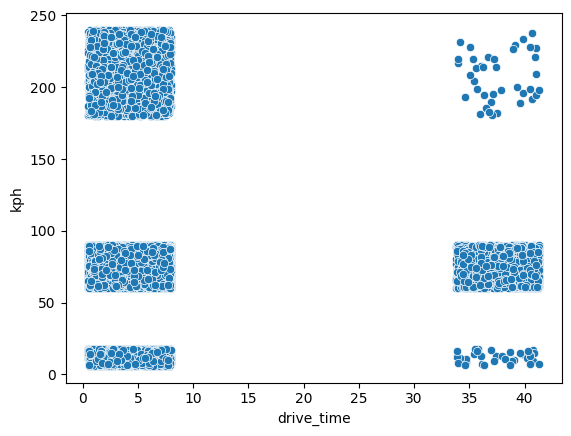

In [140]:
sns.scatterplot(x="drive_time", y="kph", data=trips_df)
# sns.displot(x="drive_time", y="km", data=trips_df[trips_df["drive_time"]<15])

In [ ]:
import pandas as pd
import numpy as np

# Create a sample dataframe (replace this with your actual dataframe)

df = trips_df[~trips_df["kph"].isna()]

# # Calculate z-scores
z_scores = (df['kph'] - df['kph'].mean()) / df['kph'].std()

# Define a threshold for outliers (e.g., |z-score| > 3)
threshold = 3

# Identify outliers
outliers = df[abs(z_scores) > threshold]

# Trim outliers
trimmed_df = df[abs(z_scores) <= threshold]

# df2 = df.copy()

# trimmed_df = transform_distribution(df[(df["kph"]<100) & (df["kph"] > 50)], df2)

# Visualize the distribution before and after trimming
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(df['kph'], bins=100, color='blue', alpha=0.7)
plt.title('Before Trimming')

plt.subplot(1, 2, 2)
plt.hist(trimmed_df['kph'], bins=100, color='green', alpha=0.7)
plt.title('After Trimming')

plt.show()
print(len(df["kph"]))
print(len(trimmed_df['kph']))


In [ ]:
sns.scatterplot(x="drive_time", y="kph", data=trimmed_df)


### Learning kph and start time relationg

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load your dataset and preprocess it
df1 = trips_df[~(trips_df["start_time"].isna()) & ~(trips_df["start_time"].isna())].copy()
df1["drive_time"] = (df1["end_time"]-df1["start_time"]) / timedelta(hours=1)
df1 = df1[df1["drive_time"] < 15]
df1["day_of_week"] = df1["start_time"].dt.day
df1["day_of_week"] = df1["day_of_week"].astype("category")
df1["is_weekend"] = df1["day_of_week"].apply(lambda x: x==5 or x==6)
df1["hour"] = df1["start_time"].dt.hour
df1["minute"] = df1["start_time"].dt.minute


def preprocess_data(df1):
    df = df1.copy()
    df["drive_time"] = (df["end_time"]-df["start_time"]) / timedelta(hours=1)
    df["day_of_week"] = df["start_time"].dt.day.astype("category")
    df["is_weekend"] = df["day_of_week"].apply(lambda x: x==5 or x==6)
    df["hour"] = df["start_time"].dt.hour
    df["minute"] = df["start_time"].dt.minute
    return df[['day_of_week', 'hour', "minute","is_weekend", "km"]],

y =  df1['kph'].values

# Split features and target variable
# X = df1[['day_of_week', 'hour', "minute", 'km']].values
# X = df1[['day_of_week', 'hour', "minute","is_weekend"]].values

# Normalize features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
# X_train = take_relevant_columns
# print(take_relevant_columns(X_train))
# print(y_train)

def select_d1_d2_columns(X):
    return X[['day_of_week', 'hour', "minute", "is_weekend", 'km']]

# model = make_pipeline(StandardScaler(), FunctionTransformer(take_relevant_columns), LinearRegression())
# model = make_pipeline(StandardScaler(), LinearRegression())
# model = LinearRegression()
# model = make_pipeline(
#        ColumnTransformer(
#         transformers=[
#             FunctionTransformer(take_relevant_columns)
#         ],
#         remainder='passthrough'  # Pass through any remaining columns
#     )
# )

model = Pipeline([
    ('preprocess', ColumnTransformer(
        transformers=[
            ('select_cols', FunctionTransformer(select_d1_d2_columns), ['day_of_week', 'hour', "minute", "is_weekend", 'km'])
        ],
        remainder='passthrough'  # Pass through any remaining columns
    )),
    ('model', LinearRegression())  # Example model, replace with your own
])

X_train, X_test, y_train, y_test = train_test_split(df1, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


ValueError: could not convert string to float: 'aminach'

In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_data(df1):
    df = df1.copy()
    df["drive_time"] = (df["end_time"]-df["start_time"]) / timedelta(hours=1)
    df["day_of_week"] = df["start_time"].dt.day.astype("category")
    df["is_weekend"] = df["day_of_week"].apply(lambda x: x==5 or x==6)
    df["hour"] = df["start_time"].dt.hour
    df["minute"] = df["start_time"].dt.minute
    return df[['day_of_week', 'hour', "minute","is_weekend", "km","kph"]]

model = Pipeline([
    ("standard scaler", StandardScaler()),
    ('model', LinearRegression())  # Example model, replace with your own
])

trips_with_times = trips_df[(~trips_df["start_time"].isna()) & (~trips_df["end_time"].isna())]

data = preprocess_data(trips_with_times)
X,y = data.drop(columns=["kph"]), data["kph"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 280.00472345252825


In [25]:
print(y_train.mean(), y_train)
# y_train.mean()
# mean_squared_error(np.full(len(X_train), X_train.mean()), X_test)
mean_squared_error(np.full(len(y_test), y.mean()), y_test)

75.75313996772151 [78.26504509 63.32067641 82.12522101 ... 69.54263897 64.84993652
 82.11685814]


299.4267493994437

<Axes: xlabel='drive_time', ylabel='kph'>

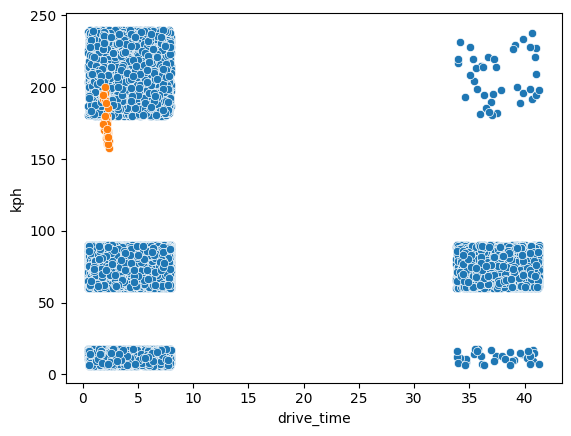

In [71]:
outliers = trips_df[(trips_df["drive_time"] >30) & ((trips_df["kph"] > 150))]

drivers_avg_km_df = trips_df[trips_df.driver_id.isin(outliers.driver_id.unique())][["driver_id", "km"]].groupby("driver_id").mean()
drivers_avg_km_df = drivers_avg_km_df.rename(columns = {"km": "avg_km"})
outliers = outliers.merge(drivers_avg_km_df, on=["driver_id"])

outliers.end_time - outliers.start_time
outliers_kph = model.predict(preprocess_data(outliers).drop(columns="kph"))
outliers_fixed_drive_time = outliers["avg_km"] / outliers_kph
outliers["fixed_drive_time"] = outliers_fixed_drive_time
outliers["predicted_kph"] = outliers_kph

sns.scatterplot(x="drive_time", y="kph" , data=trips_df)
sns.scatterplot(x="fixed_drive_time", y="predicted_kph" , data=outliers)



C:\Users\Ron Tohar\AppData\Local\Temp\ipykernel_12328\3630365044.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_slow["fixed_drive_time"] = outliers_slow_fixed_drive_time
C:\Users\Ron Tohar\AppData\Local\Temp\ipykernel_12328\3630365044.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_slow["predicted_kph"] = outliers_slow_kph


<Axes: xlabel='drive_time', ylabel='kph'>

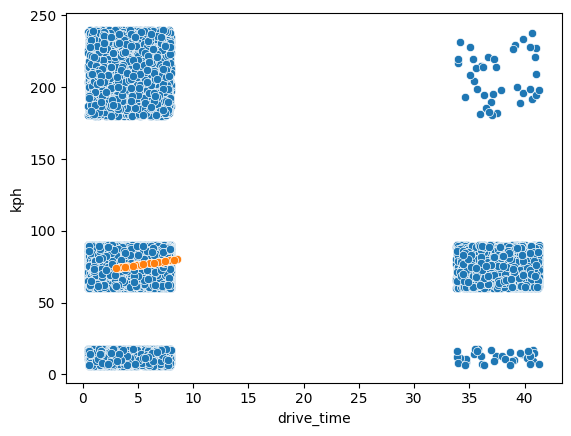

In [75]:
outliers_slow = trips_df[(trips_df["drive_time"] >30) & ((trips_df["kph"] < 50))]
outliers_slow_kph = model.predict(preprocess_data(outliers_slow).drop(columns="kph"))

outliers_slow_fixed_drive_time = outliers_slow["km"] / outliers_slow_kph
outliers_slow["fixed_drive_time"] = outliers_slow_fixed_drive_time
outliers_slow["predicted_kph"] = outliers_slow_kph

sns.scatterplot(x="drive_time", y="kph" , data=trips_df)
sns.scatterplot(x="fixed_drive_time", y="predicted_kph" , data=outliers_slow)
# 
# outliers_slow

